In [1]:
import pandas as pd
from datetime import datetime
from pandas import DataFrame
from pandas import read_csv
#h=pd.read_csv("Clearness Index3.csv" )

#h1=h.drop([ 'insolation_clearness_index','temp','Min_temp','Claer_sky_ii','humidity','dew/frost_point','max_temp','wind_s','precipitation'], axis=1)
#h1.to_csv('All_sky_ii.csv',  index = None)
h1=pd.read_csv("All_sky_ii2.csv" )

number = 24
elements = 1127

thelist = [number] * elements
h1['thelist'] = thelist

Hour = ['01','02','03','04','05','06','07','08', '09','10','11','12','13','14','15','16','17','18','19','20','21','22','23','00']

elements = 1127

Hour = [Hour] * elements

my_new_list = []
for sub_list in Hour:
    # Now go over each item of the sublist
    for item in sub_list:
        # append it to our new list
        my_new_list.append(item)
        
        out =h1.reindex(h1.index.repeat(h1['thelist']))
h1=out.drop(['thelist'], axis=1)

h1['Hour'] = my_new_list
h1["DateTime"] = (h1["date"] +" "+ h1["Hour"])
h_data=h1.drop(['date','Hour'],axis=1)


h_data['DateTime'] = pd.to_datetime(h_data['DateTime'])

h_data=h_data.set_index(h_data['DateTime'], drop=False, append=False, inplace=False, verify_integrity=False).drop('DateTime', 1)
h_data.columns=['All_Sky_Insolation_Incident']

#h_data

In [2]:

d = pd.read_csv("load3.csv" )

d.columns = ['date' ,'01','02','03','04','05','06','07','08', '09','10','11','12','13','14','15','16','17','18','19','20','21','22','23','00']
d.to_csv('load3.csv',  index = None)

from pandas import DataFrame

# read first line
with open("load3.csv") as myfile:
    headRow = next(myfile)

# read column names    
columns = [x.strip() for x in headRow.split(',')]

# process by pandas
data = pd.read_csv("load3.csv", names=columns[1:], skiprows=1)

stacked=data.stack()

stacked = stacked.to_frame()
stacked.columns=['Load']
s=stacked.reset_index()
s.columns=['Date','Hour','Load']
s["DateTime"] = (s["Date"] +" "+ s["Hour"])
s = s[["DateTime","Load"]]
from datetime import datetime

s['DateTime'] = pd.to_datetime(s['DateTime'])
dataset=s.set_index(s['DateTime'], drop=False, append=False, inplace=False, verify_integrity=False).drop('DateTime', 1)
#dataset

df=pd.merge(dataset,h_data,on='DateTime')

df

,Load,All_Sky_Insolation_Incident
DateTime,,
1987-01-01 01:00:00,1733,0.68
1987-01-01 02:00:00,1636,0.68
1987-01-01 03:00:00,1564,0.68
1987-01-01 04:00:00,1526,0.68
1987-01-01 05:00:00,1515,0.68
...,...,...
1990-01-31 20:00:00,3361,3.88
1990-01-31 21:00:00,3205,3.88
1990-01-31 22:00:00,2940,3.88


In [3]:
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [4]:
import numpy as np

train_size = int(len(df) * 0.6)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

test_size = int(len(test) * 0.5)
val_size = len(test) - test_size
val, test = test.iloc[0:test_size], test.iloc[test_size:len(test)]
print(len(test), len(val))

16228 10820
5410 5410


In [5]:
train,val,test

(                     Load  All_Sky_Insolation_Incident
 DateTime                                              
 1987-01-01 01:00:00  1733                         0.68
 1987-01-01 02:00:00  1636                         0.68
 1987-01-01 03:00:00  1564                         0.68
 1987-01-01 04:00:00  1526                         0.68
 1987-01-01 05:00:00  1515                         0.68
 ...                   ...                          ...
 1988-11-06 00:00:00  1707                         3.13
 1988-11-07 01:00:00  1552                         1.79
 1988-11-07 02:00:00  1514                         1.79
 1988-11-07 03:00:00  1499                         1.79
 1988-11-07 04:00:00  1531                         1.79
 
 [16228 rows x 2 columns],
                      Load  All_Sky_Insolation_Incident
 DateTime                                              
 1988-11-07 05:00:00  1620                         1.79
 1988-11-07 06:00:00  1947                         1.79
 1988-11-07 07:00:0

In [6]:
from sklearn.preprocessing import MinMaxScaler

f_columns = ['All_Sky_Insolation_Incident']

f_transformer = MinMaxScaler()
t_transformer = MinMaxScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
t_transformer = t_transformer.fit(train[['Load']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['Load'] = t_transformer.transform(train[['Load']])

val.loc[:, f_columns] = f_transformer.transform(val[f_columns].to_numpy())
val['Load'] = t_transformer.transform(val[['Load']])


test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['Load'] = t_transformer.transform(test[['Load']])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [7]:
n_hours = 24
n_features = 2
# frame as supervised learning
tarin_reframed = series_to_supervised(train, n_hours, 24)
test_reframed = series_to_supervised(test, n_hours, 24)
val_reframed = series_to_supervised(val, n_hours, 24)



# split into train and test sets
train_values = tarin_reframed.values
test_values = test_reframed.values
val_values = val_reframed.values

#n_train_hours = 21614
#train2 = values[:n_train_hours, :]
#test2 = values[n_train_hours:, :]

# split into input and outputs
n_obs = n_hours * n_features

train_X, train_y = train_values[:, :n_obs], train_values[:, -n_features]
test_X, test_y = test_values[:, :n_obs], test_values[:, -n_features]
val_X, val_y = val_values[:, :n_obs], val_values[:, -n_features]


# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
val_X = val_X.reshape((val_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape,val_X.shape,  val_y.shape,test_X.shape, test_y.shape)

(16181, 24, 2) (16181,) (5363, 24, 2) (5363,) (5363, 24, 2) (5363,)


In [8]:
!pip install keras_tuner

     |████████████████████████████████| 98 kB 5.3 MB/s 


In [9]:
import pandas as pd
import math
import keras
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import save_model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
import keras_tuner
#from kerastuner.tuners import RandomSearch
#from kerastuner.engine.hyperparameters import HyperParameters
from pickle import dump,load
from keras_tuner import RandomSearch
from keras_tuner import HyperModel
from keras_tuner import HyperParameters
import warnings
warnings.simplefilter("ignore", UserWarning)
from tensorflow.keras import layers


In [10]:
from tensorflow.keras.callbacks import EarlyStopping
custom_early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    min_delta=0.001, #10^-3
    mode='auto'
)

In [11]:
import tensorflow as tf
def build_model(hp):
    model = keras.Sequential()
    
    
    model.add(layers.LSTM(units=hp.Int('units_1' ,
                                            min_value=32,
                                            max_value=612,
                                            step=32),
                          input_shape=(train_X.shape[1], train_X.shape[2])
                             ,return_sequences=True))
    
    model.add(layers.LSTM(units=hp.Int('Last_units' ,
                                            min_value=32,
                                            max_value=612,
                                            step=32) ))
   
    
    
    #model.add(layers.Dropout(rate=0.25)) 

    model.add(layers.Dense(1))
    model.compile(
        optimizer=tf.keras.optimizers.Adam( ),
        loss='mean_squared_error',
        metrics=['mse'])
    return model

In [12]:
tuner = RandomSearch(
    build_model,
    objective='val_mse',
    max_trials=3,
    executions_per_trial=1,
    overwrite=True
)

In [13]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 612, 'step': 32, 'sampling': None}
Last_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 612, 'step': 32, 'sampling': None}


In [14]:
tuner.search(
        x=train_X,
        y= train_y,
        epochs=200,
        batch_size=32,
        validation_data=(val_X, val_y),
        callbacks=[custom_early_stopping]
)

Trial 3 Complete [00h 08m 56s]
val_mse: 0.00288841943256557

Best val_mse So Far: 0.0028042024932801723
Total elapsed time: 00h 41m 28s
INFO:tensorflow:Oracle triggered exit


In [15]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='val_mse', direction='min')
Trial summary
Hyperparameters:
units_1: 416
Last_units: 160
Score: 0.0028042024932801723
Trial summary
Hyperparameters:
units_1: 128
Last_units: 448
Score: 0.00288841943256557
Trial summary
Hyperparameters:
units_1: 576
Last_units: 448
Score: 0.0030624798964709044


In [ ]:
model=tuner.get_best_models()[0]
history=model.fit(X_train,y_train, epochs=1, validation_data=(X_validate, y_validate),
                  callbacks=[custom_early_stopping])

507/507 [==============================] - 238s 434ms/step - loss: 2.4614e-04 - mse: 2.4614e-04 - val_loss: 1.8640e-04 - val_mse: 1.8640e-04


In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 64)            17152     
                                                                 
 lstm_1 (LSTM)               (None, 24, 384)           689664    
                                                                 
 lstm_2 (LSTM)               (None, 24, 288)           775296    
                                                                 
 lstm_3 (LSTM)               (None, 192)               369408    
                                                                 
 dense (Dense)               (None, 1)                 193       
                                                                 
Total params: 1,851,713
Trainable params: 1,851,713
Non-trainable params: 0
_________________________________________________________________


dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


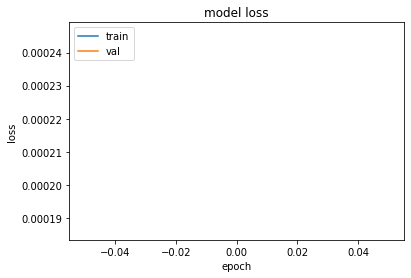

In [ ]:
from matplotlib import pyplot
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')


In [ ]:
y_pred = model.predict(X_test)

In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error


###### ???????#####
y_train_inv = t_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = t_transformer.inverse_transform(y_test.reshape((len(y_test), 1)))
y_pred_inv = t_transformer.inverse_transform(y_pred)

In [ ]:
# calculate RMSE
rmse = sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 49.396


In [ ]:
actual_test=y_test_inv
Nrmse_test=rmse /(actual_test.max() - actual_test.min())

print(Nrmse_test)

0.019726662295672357


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(y_test_inv, y_pred_inv)

0.01780175252219751

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test_inv, y_pred_inv)

36.75902923685974